In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
os.chdir(r"C:\Users\User\OneDrive\Документы\Kaggle\Placement Puzzle Crack the Hiring Code")

In [3]:
X = pd.read_csv("Train_Features.csv")
y = pd.read_csv("Train_Target.csv")
X.head()

,ID,Gender,Percent_SSC,Board_SSC,Percent_HSC,Board_HSC,Stream_HSC,Percent_Degree,Course_Degree,Experience_Yrs,Entrance_Test,S-TEST,Percentile_ET,S-TEST*SCORE,Percent_MBA,Specialization_MBA,Marks_Communication,Marks_Projectwork,Marks_BOCA
0,1,M,56.0,ICSE,58.0,ISC,Commerce,67.00,Management,0,NaN,0,0.0,0.0,65.28,Marketing & Finance,62,77,77
1,2,M,41.0,Others,51.0,Others,Science,61.00,Computer Applications,1,MAT,1,86.0,86.0,62.48,Marketing & Finance,59,72,75
2,3,F,53.0,Others,40.0,Others,Arts,54.00,Arts,1,MAT,1,65.0,65.0,56.11,Marketing & HR,54,66,75
3,4,M,59.0,Others,58.0,Others,Commerce,59.00,Management,0,G-MAT,1,0.0,0.0,59.81,Marketing & HR,53,66,78
4,5,F,61.5,Others,65.4,CBSE,Arts,67.93,Management,0,MAT,1,61.0,61.0,64.27,Marketing & Finance,69,69,61


In [6]:
y.head()

,ID,Placement
0,1,1
1,2,0
2,3,1
3,4,0
4,5,0


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   300 non-null    int64  
 1   Gender               300 non-null    object 
 2   Percent_SSC          300 non-null    float64
 3   Board_SSC            300 non-null    object 
 4   Percent_HSC          300 non-null    float64
 5   Board_HSC            300 non-null    object 
 6   Stream_HSC           300 non-null    object 
 7   Percent_Degree       300 non-null    float64
 8   Course_Degree        300 non-null    object 
 9   Experience_Yrs       300 non-null    int64  
 10  Entrance_Test        247 non-null    object 
 11  S-TEST               300 non-null    int64  
 12  Percentile_ET        300 non-null    float64
 13  S-TEST*SCORE         300 non-null    float64
 14  Percent_MBA          300 non-null    float64
 15  Specialization_MBA   300 non-null    obj

<AxesSubplot:>

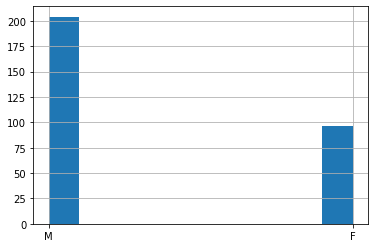

In [57]:
X["Gender"].hist()

In [8]:
X.groupby(["Board_SSC"]).agg("count")["ID"]

Board_SSC
CBSE       93
ICSE       53
Others    154
Name: ID, dtype: int64

In [9]:
X.groupby(["Board_HSC"]).agg("count")["ID"]

Board_HSC
CBSE       74
ISC        35
Others    191
Name: ID, dtype: int64

In [10]:
X["Course_Degree"].unique()

array(['Management', 'Computer Applications', 'Arts', 'Commerce',
       'Science', 'Engineering', 'Others'], dtype=object)

<AxesSubplot:xlabel='Course_Degree'>

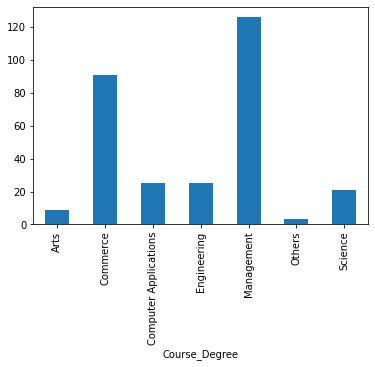

In [11]:
X.groupby(["Course_Degree"]).agg("count")["ID"].plot(kind="bar")

<AxesSubplot:xlabel='Entrance_Test'>

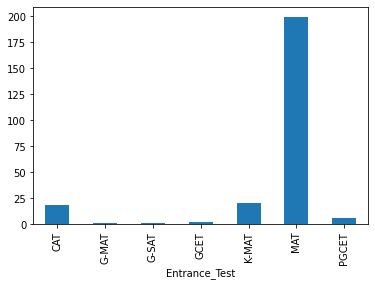

In [12]:
X.groupby(["Entrance_Test"]).agg("count")["ID"].plot(kind="bar")

<AxesSubplot:xlabel='Specialization_MBA'>

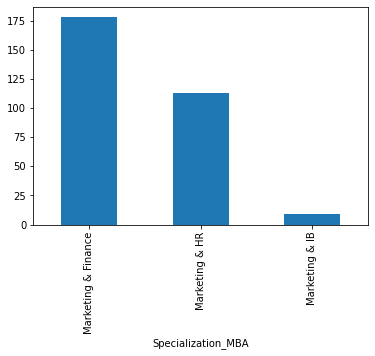

In [13]:
X.groupby(["Specialization_MBA"]).agg("count")["ID"].plot(kind="bar")

<AxesSubplot:>

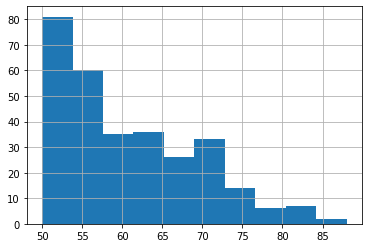

In [32]:
X["Marks_Communication"].hist()

<AxesSubplot:>

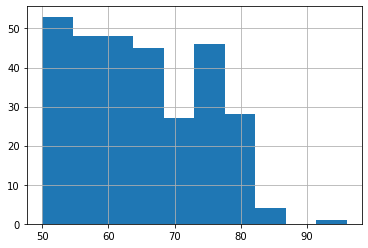

In [33]:
X["Marks_BOCA"].hist()

In [23]:
X.merge(y, on="ID").corr().style.background_gradient(cmap='coolwarm')

,ID,Percent_SSC,Percent_HSC,Percent_Degree,Experience_Yrs,S-TEST,Percentile_ET,S-TEST*SCORE,Percent_MBA,Marks_Communication,Marks_Projectwork,Marks_BOCA,Placement
ID,1.000000,0.028451,0.023839,-0.044429,-0.030488,-0.035575,-0.073602,-0.073602,0.047562,-0.005577,0.027050,0.057913,-0.042509
Percent_SSC,0.028451,1.000000,0.433148,0.423459,-0.030588,0.075147,0.192465,0.192465,0.470392,0.476841,0.112546,0.246352,-0.183258
Percent_HSC,0.023839,0.433148,1.000000,0.354127,-0.051641,0.016663,0.124581,0.124581,0.385015,0.339803,0.135989,0.109658,-0.082300
Percent_Degree,-0.044429,0.423459,0.354127,1.000000,-0.065430,0.112413,0.205817,0.205817,0.434477,0.404207,0.185281,0.272068,-0.057246
Experience_Yrs,-0.030488,-0.030588,-0.051641,-0.065430,1.000000,-0.078365,-0.019673,-0.019673,0.146860,0.084021,0.156182,0.176340,-0.035116
S-TEST,-0.035575,0.075147,0.016663,0.112413,-0.078365,1.000000,0.814032,0.814032,0.041751,0.061539,0.073828,-0.037564,-0.048281
Percentile_ET,-0.073602,0.192465,0.124581,0.205817,-0.019673,0.814032,1.000000,1.000000,0.157267,0.133746,0.115103,0.080736,-0.131428
S-TEST*SCORE,-0.073602,0.192465,0.124581,0.205817,-0.019673,0.814032,1.000000,1.000000,0.157267,0.133746,0.115103,0.080736,-0.131428
Percent_MBA,0.047562,0.470392,0.385015,0.434477,0.146860,0.041751,0.157267,0.157267,1.000000,0.710685,0.398361,0.446068,-0.094157
Marks_Communication,-0.005577,0.476841,0.339803,0.404207,0.084021,0.061539,0.133746,0.133746,0.710685,1.000000,0.286855,0.180845,-0.019092


C:\Users\User\AppData\Local\Temp\ipykernel_6152\3089025668.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(X.drop(["ID", "Experience_Yrs"], axis=1), ax=ax, alpha=0.5, s=300);


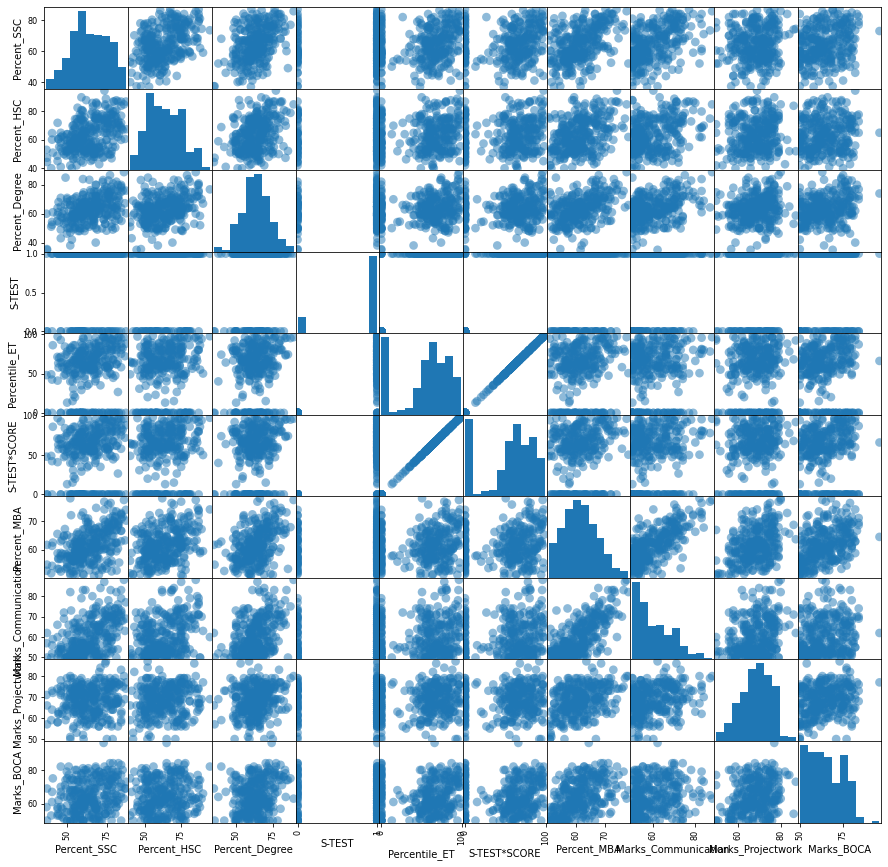

In [31]:
fix, ax = plt.subplots(figsize=(15, 15))
pd.plotting.scatter_matrix(X.drop(["ID", "Experience_Yrs"], axis=1), ax=ax, alpha=0.5, s=300);

C:\Users\User\AppData\Local\Temp\ipykernel_6152\3386380533.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(X[["S-TEST", "Percentile_ET", "S-TEST*SCORE"]], ax=ax, alpha=0.5, s=300);


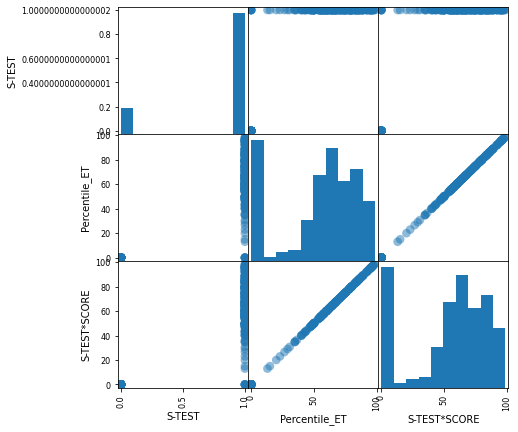

In [45]:
fig, ax = plt.subplots(figsize=(7, 7))
pd.plotting.scatter_matrix(X[["S-TEST", "Percentile_ET", "S-TEST*SCORE"]], ax=ax, alpha=0.5, s=300);

<AxesSubplot:>

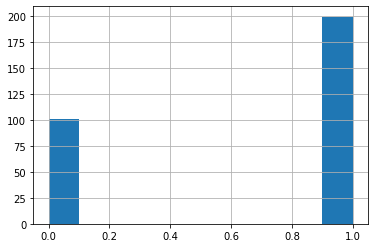

In [56]:
X["Entrance_Test"].apply(lambda x: 1 if x == "MAT" else 0).hist()

In [4]:
def wrangle(input):
    df = input.copy()
    # Fill in missing data
    df["Entrance_Test"].fillna("MAT", inplace=True)
    # Drop highly correlated features
    corr = ["S-TEST", "Percentile_ET"]
    df.drop(corr, axis=1, inplace=True)
    # Squish highly categorical data
    df["Course_Degree"] = df["Course_Degree"].apply(lambda x: "Science" if x in ("Computer Applications", "Engineering") else x)
    df["Course_Degree"] = df["Course_Degree"].apply(lambda x: "Others" if x == "Arts" else x)
    df["MAT"] = df["Entrance_Test"].apply(lambda x: 1 if x == "MAT" else 0)
    df.drop(["ID", "Entrance_Test"], axis=1, inplace=True)
    return df

In [5]:
X_rd = wrangle(X)
X_rd.head()

,Gender,Percent_SSC,Board_SSC,Percent_HSC,Board_HSC,Stream_HSC,Percent_Degree,Course_Degree,Experience_Yrs,S-TEST*SCORE,Percent_MBA,Specialization_MBA,Marks_Communication,Marks_Projectwork,Marks_BOCA,MAT
0,M,56.0,ICSE,58.0,ISC,Commerce,67.00,Management,0,0.0,65.28,Marketing & Finance,62,77,77,1
1,M,41.0,Others,51.0,Others,Science,61.00,Science,1,86.0,62.48,Marketing & Finance,59,72,75,1
2,F,53.0,Others,40.0,Others,Arts,54.00,Others,1,65.0,56.11,Marketing & HR,54,66,75,1
3,M,59.0,Others,58.0,Others,Commerce,59.00,Management,0,0.0,59.81,Marketing & HR,53,66,78,0
4,F,61.5,Others,65.4,CBSE,Arts,67.93,Management,0,61.0,64.27,Marketing & Finance,69,69,61,1


In [83]:
X_rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   300 non-null    int64  
 1   Gender               300 non-null    object 
 2   Percent_SSC          300 non-null    float64
 3   Board_SSC            300 non-null    object 
 4   Percent_HSC          300 non-null    float64
 5   Board_HSC            300 non-null    object 
 6   Stream_HSC           300 non-null    object 
 7   Percent_Degree       300 non-null    float64
 8   Course_Degree        300 non-null    object 
 9   Experience_Yrs       300 non-null    int64  
 10  S-TEST*SCORE         300 non-null    float64
 11  Percent_MBA          300 non-null    float64
 12  Specialization_MBA   300 non-null    object 
 13  Marks_Communication  300 non-null    int64  
 14  Marks_Projectwork    300 non-null    int64  
 15  Marks_BOCA           300 non-null    int

In [71]:
X_rd.merge(y, on="ID").corr().style.background_gradient(cmap='coolwarm')

,ID,Percent_SSC,Percent_HSC,Percent_Degree,Experience_Yrs,Entrance_Test,S-TEST*SCORE,Percent_MBA,Marks_Communication,Marks_Projectwork,Marks_BOCA,Placement
ID,1.000000,0.028451,0.023839,-0.044429,-0.030488,-0.082313,-0.073602,0.047562,-0.005577,0.027050,0.057913,-0.042509
Percent_SSC,0.028451,1.000000,0.433148,0.423459,-0.030588,-0.025326,0.192465,0.470392,0.476841,0.112546,0.246352,-0.183258
Percent_HSC,0.023839,0.433148,1.000000,0.354127,-0.051641,0.004259,0.124581,0.385015,0.339803,0.135989,0.109658,-0.082300
Percent_Degree,-0.044429,0.423459,0.354127,1.000000,-0.065430,-0.017828,0.205817,0.434477,0.404207,0.185281,0.272068,-0.057246
Experience_Yrs,-0.030488,-0.030588,-0.051641,-0.065430,1.000000,0.057297,-0.019673,0.146860,0.084021,0.156182,0.176340,-0.035116
Entrance_Test,-0.082313,-0.025326,0.004259,-0.017828,0.057297,1.000000,-0.046781,-0.030852,-0.091550,-0.081896,0.032387,0.017169
S-TEST*SCORE,-0.073602,0.192465,0.124581,0.205817,-0.019673,-0.046781,1.000000,0.157267,0.133746,0.115103,0.080736,-0.131428
Percent_MBA,0.047562,0.470392,0.385015,0.434477,0.146860,-0.030852,0.157267,1.000000,0.710685,0.398361,0.446068,-0.094157
Marks_Communication,-0.005577,0.476841,0.339803,0.404207,0.084021,-0.091550,0.133746,0.710685,1.000000,0.286855,0.180845,-0.019092
Marks_Projectwork,0.027050,0.112546,0.135989,0.185281,0.156182,-0.081896,0.115103,0.398361,0.286855,1.000000,0.242000,-0.157975


C:\Users\User\AppData\Local\Temp\ipykernel_6152\3089025668.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(X.drop(["ID", "Experience_Yrs"], axis=1), ax=ax, alpha=0.5, s=300);
C:\Users\User\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


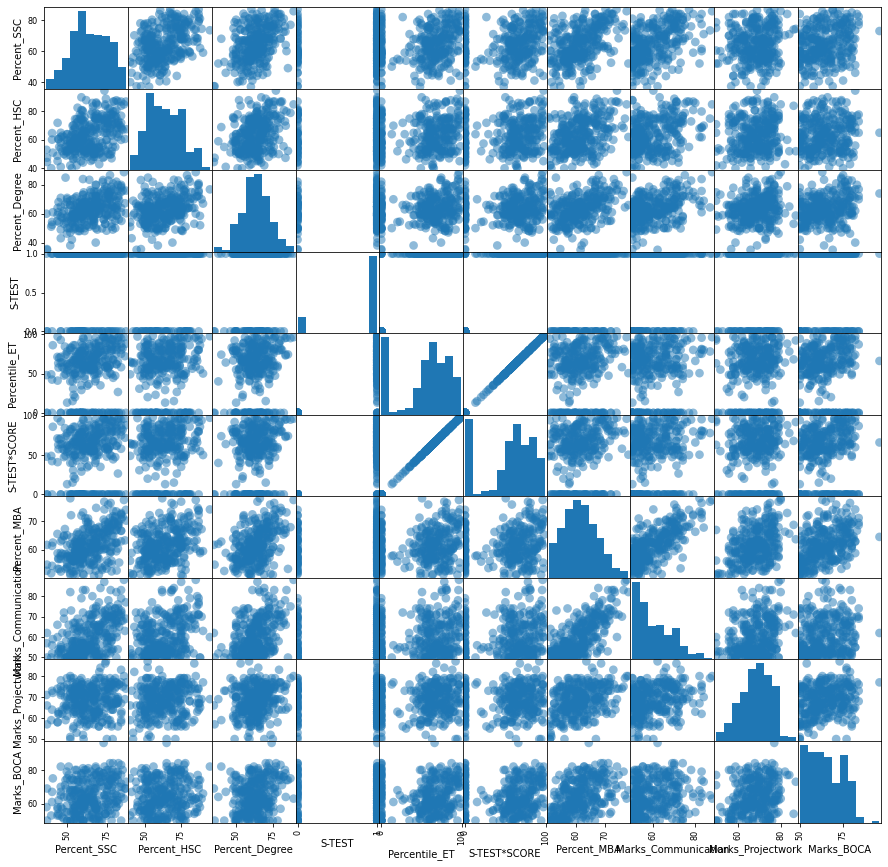

In [80]:
fix, ax = plt.subplots(figsize=(15, 15))
pd.plotting.scatter_matrix(X_rd.drop(["ID", "Experience_Yrs"], axis=1), ax=ax, alpha=0.5, s=300);

In [ ]:
X_rd = X_rd.drop("ID", axis=1)
y = y.drop("ID", axis=1)

In [7]:
X_rd = pd.get_dummies(X_rd)
X_rd

,Percent_SSC,Percent_HSC,Percent_Degree,Experience_Yrs,S-TEST*SCORE,Percent_MBA,Marks_Communication,Marks_Projectwork,Marks_BOCA,MAT,...,Stream_HSC_Arts,Stream_HSC_Commerce,Stream_HSC_Science,Course_Degree_Commerce,Course_Degree_Management,Course_Degree_Others,Course_Degree_Science,Specialization_MBA_Marketing & Finance,Specialization_MBA_Marketing & HR,Specialization_MBA_Marketing & IB
0,56.00,58.00,67.00,0,0.00,65.28,62,77,77,1,...,0,1,0,0,1,0,0,1,0,0
1,41.00,51.00,61.00,1,86.00,62.48,59,72,75,1,...,0,0,1,0,0,0,1,1,0,0
2,53.00,40.00,54.00,1,65.00,56.11,54,66,75,1,...,1,0,0,0,0,1,0,0,1,0
3,59.00,58.00,59.00,0,0.00,59.81,53,66,78,0,...,0,1,0,0,1,0,0,0,1,0
4,61.50,65.40,67.93,0,61.00,64.27,69,69,61,1,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,64.60,63.40,76.30,1,60.00,63.70,71,69,70,1,...,0,1,0,1,0,0,0,1,0,0
296,52.00,57.00,47.00,1,83.00,57.61,50,74,74,1,...,0,1,0,0,1,0,0,1,0,0
297,86.40,60.66,67.25,0,72.00,63.23,63,69,69,1,...,0,0,1,0,0,0,1,0,1,0
298,44.00,72.00,59.00,0,41.00,58.75,50,58,57,1,...,0,1,0,0,1,0,0,0,0,1


In [69]:
dtc_clf = DecisionTreeClassifier(random_state=42)

In [125]:
params_dtc = {"max_depth": range(1, 51)}

In [126]:
dtc = GridSearchCV(dtc_clf, cv=5, n_jobs=-1, verbose=2, param_grid=params_dtc, scoring="f1", error_score='raise', return_train_score=True)
dtc.fit(X_rd, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 51)}, return_train_score=True,
             scoring='f1', verbose=2)

In [127]:
dtc.best_score_

0.30859326788218794

In [128]:
dtc.best_params_

{'max_depth': 10}

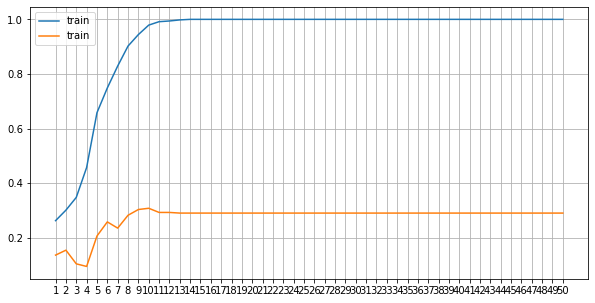

In [129]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(params_dtc["max_depth"], dtc.cv_results_["mean_train_score"], label="train")
ax.plot(params_dtc["max_depth"], dtc.cv_results_["mean_test_score"], label="train")
plt.legend()
plt.grid()
plt.xticks(range(1, 51));

In [86]:
decision_tree = dtc.best_estimator_

In [132]:
print(f"f1 score of a decision tree is {dtc.best_score_}")

f1 score of a decision tree is 0.30859326788218794


In [182]:
decision_tree_raw_importances = sorted(enumerate(decision_tree.feature_importances_), key=lambda x: x[1], reverse=False)
decision_tree_importances = []
decision_tree_importances_names = []
for indx, importance in decision_tree_raw_importances:
    decision_tree_importances_names.append(X_rd.columns[indx])
    decision_tree_importances.append(importance)


<BarContainer object of 28 artists>

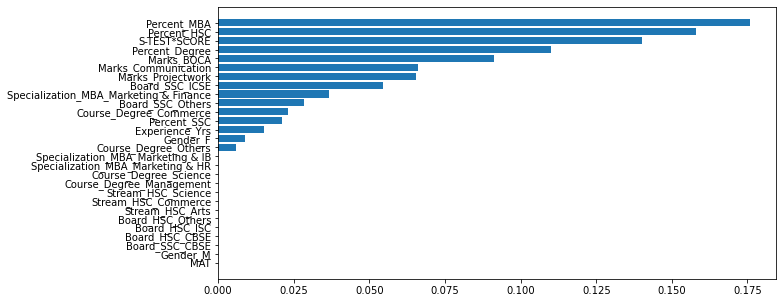

In [183]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(width=decision_tree_importances, y=decision_tree_importances_names)

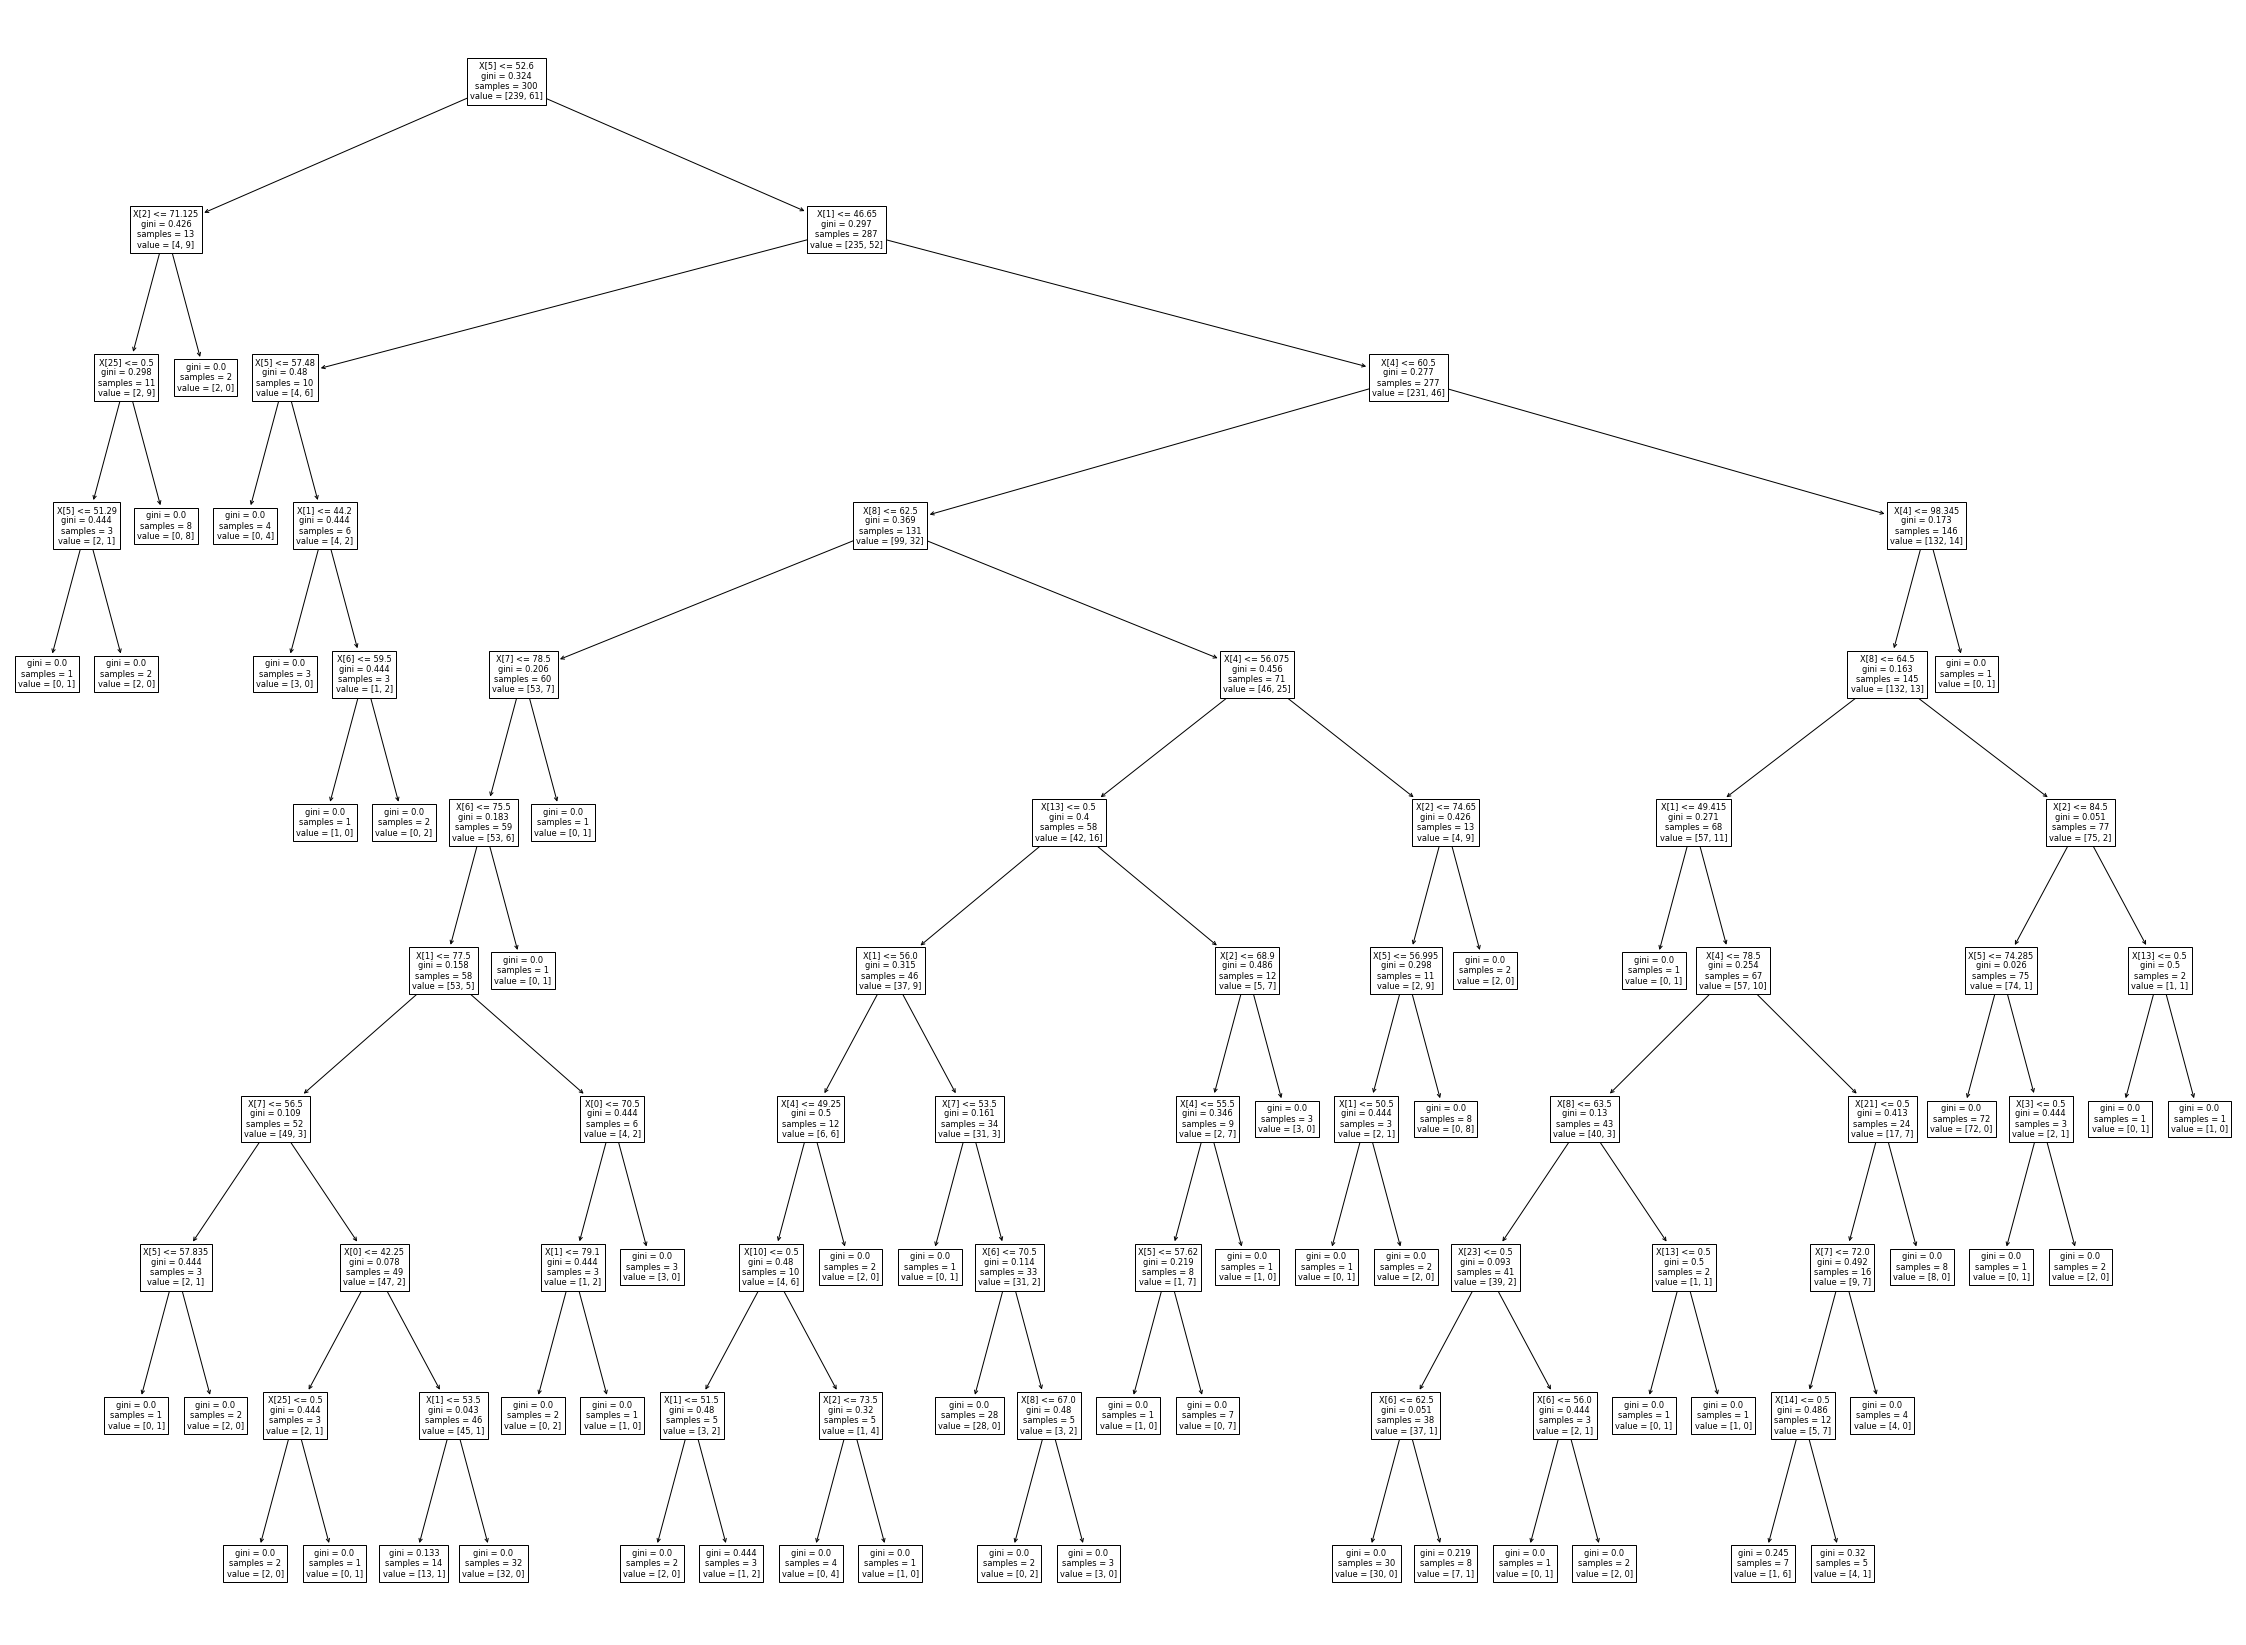

In [131]:
fig, ax = plt.subplots(figsize=(40, 30))
plot_tree(decision_tree, ax=ax);

In [180]:
with open("decision_tree.pkl", "wb") as f:
    pickle.dump(decision_tree, f)

In [98]:
with open("decision_tree.pkl", "rb") as f:
    decision_tree = pickle.load(f)
decision_tree.feature_importances_

array([0.02114058, 0.15799849, 0.10992375, 0.01499162, 0.139963  ,
       0.17571084, 0.06592574, 0.06549985, 0.09122681, 0.        ,
       0.00899497, 0.        , 0.        , 0.05465367, 0.02832345,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02295592, 0.        , 0.00589369, 0.        ,
       0.03679761, 0.        , 0.        ])

In [155]:
rfc_clf = RandomForestClassifier(random_state=42)

In [157]:
params_rfc = {
    "max_depth": range(1, 11),
    "n_estimators": range(100, 301),
    "min_samples_split": np.arange(0.01, 1, 0.01)
}

In [171]:
params_rfc1 = {
    "max_depth": range(10, 30),
    "n_estimators": range(5, 101)
}

In [159]:
rfc = RandomizedSearchCV(rfc_clf, param_distributions=params_rfc, n_iter=10000, scoring="f1", n_jobs=-1, cv=5, random_state=42, verbose=2, error_score="raise")
rfc.fit(X_rd, y)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=10000, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 11),
                                        'min_samples_split': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                                        'n_estimators

In [19]:
rfc1 = GridSearchCV(rfc_clf, param_grid=params_rfc1, scoring="f1", n_jobs=-1, cv=5, verbose=2, error_score="raise")
rfc1.fit(X_rd, y)

NameError: name 'rfc_clf' is not defined

In [173]:
rfc1.best_params_

{'max_depth': 12, 'n_estimators': 7}

In [174]:
rfc1.best_score_

0.24220439691027926

In [175]:
random_forest = rfc1.best_estimator_

In [176]:
random_forest_raw_importances = sorted(enumerate(random_forest.feature_importances_), key=lambda x: x[1], reverse=False)
random_forest_importances = []
random_forest_importances_names = []
for indx, importance in random_forest_raw_importances:
    random_forest_importances_names.append(X_rd.columns[indx])
    random_forest_importances.append(importance)


<BarContainer object of 28 artists>

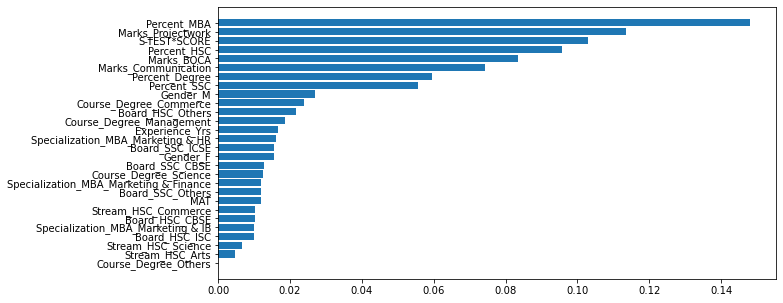

In [177]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(width=random_forest_importances, y=random_forest_importances_names)

In [184]:
with open("random_forest.pkl", "wb") as f:
    pickle.dump(random_forest, f)

In [97]:
with open("random_forest.pkl", "rb") as f:
    random_forest = pickle.load(f)
random_forest.feature_importances_

array([0.05549928, 0.09560823, 0.05947408, 0.01677159, 0.1030625 ,
       0.14791227, 0.07413487, 0.11362099, 0.08346357, 0.01177676,
       0.01540445, 0.02699554, 0.01267179, 0.0154294 , 0.01179312,
       0.01016683, 0.00986239, 0.02173133, 0.00470923, 0.01037352,
       0.00668703, 0.02383493, 0.01856092, 0.        , 0.01248918,
       0.01205005, 0.01595583, 0.0099603 ])

In [9]:
from catboost import CatBoostClassifier

In [29]:
cbc_clf = CatBoostClassifier(random_state=42, cat_features=["Gender", "Board_SSC", "Board_HSC", "Stream_HSC", "Course_Degree", "Specialization_MBA"], logging_level='Silent', eval_metric="F1")

In [30]:
X_rd

,Gender,Percent_SSC,Board_SSC,Percent_HSC,Board_HSC,Stream_HSC,Percent_Degree,Course_Degree,Experience_Yrs,S-TEST*SCORE,Percent_MBA,Specialization_MBA,Marks_Communication,Marks_Projectwork,Marks_BOCA,MAT
0,M,56.00,ICSE,58.00,ISC,Commerce,67.00,Management,0,0.00,65.28,Marketing & Finance,62,77,77,1
1,M,41.00,Others,51.00,Others,Science,61.00,Science,1,86.00,62.48,Marketing & Finance,59,72,75,1
2,F,53.00,Others,40.00,Others,Arts,54.00,Others,1,65.00,56.11,Marketing & HR,54,66,75,1
3,M,59.00,Others,58.00,Others,Commerce,59.00,Management,0,0.00,59.81,Marketing & HR,53,66,78,0
4,F,61.50,Others,65.40,CBSE,Arts,67.93,Management,0,61.00,64.27,Marketing & Finance,69,69,61,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,M,64.60,CBSE,63.40,CBSE,Commerce,76.30,Commerce,1,60.00,63.70,Marketing & Finance,71,69,70,1
296,M,52.00,CBSE,57.00,CBSE,Commerce,47.00,Management,1,83.00,57.61,Marketing & Finance,50,74,74,1
297,M,86.40,Others,60.66,Others,Science,67.25,Science,0,72.00,63.23,Marketing & HR,63,69,69,1
298,M,44.00,Others,72.00,Others,Commerce,59.00,Management,0,41.00,58.75,Marketing & IB,50,58,57,1


In [33]:
params_cbc = {
    "iterations": range(10, 1000, 100),
    "learning_rate": np.arange(0.01, 0.5, 0.01),
    "depth": range(4, 10),
    "l2_leaf_reg": range(10)
}

In [34]:
cbc = cbc_clf.randomized_search(param_distributions=params_cbc, partition_random_seed=42, n_iter=1000, cv=5, X=X_rd, y=y.drop("ID", axis=1), verbose=100)

0:	loss: 0.0000000	best: 0.0000000 (0)	total: 110ms	remaining: 1m 49s
100:	loss: 0.2857143	best: 0.4545455 (47)	total: 5m 42s	remaining: 50m 46s
200:	loss: 0.2222222	best: 0.4545455 (47)	total: 14m 55s	remaining: 59m 20s
300:	loss: 0.2222222	best: 0.4545455 (47)	total: 26m 24s	remaining: 1h 1m 19s
400:	loss: 0.2105263	best: 0.4545455 (47)	total: 37m 16s	remaining: 55m 41s
500:	loss: 0.3333333	best: 0.4545455 (47)	total: 54m 49s	remaining: 54m 36s
600:	loss: 0.2222222	best: 0.4545455 (47)	total: 1h 3m 56s	remaining: 42m 26s
700:	loss: 0.1904762	best: 0.4545455 (47)	total: 1h 21m 55s	remaining: 34m 56s
800:	loss: 0.1250000	best: 0.4545455 (47)	total: 1h 41m 58s	remaining: 25m 20s
900:	loss: 0.1250000	best: 0.4545455 (47)	total: 1h 59m 20s	remaining: 13m 6s
999:	loss: 0.0000000	best: 0.4545455 (47)	total: 2h 34m 10s	remaining: 0us
Estimating final quality...


In [35]:
cbc["params"]

{'depth': 4, 'learning_rate': 0.24, 'l2_leaf_reg': 0, 'iterations': 310}

In [39]:
catboost = cbc_clf

In [40]:
catboost.save_model("catboost")

In [50]:
with open("catboost.pkl", "wb") as f:
    pickle.dump(catboost, f)

In [96]:
with open("catboost.pkl", "rb") as f:
    catboost = pickle.load(f)

In [36]:
catboost.get_feature_importance()

NameError: name 'catboost' is not defined

In [37]:
catboost_raw_importances = sorted(enumerate(catboost.get_feature_importance()), key=lambda x: x[1], reverse=False)
catboost_importances = []
catboost_importances_names = []
for indx, importance in catboost_raw_importances:
    catboost_importances_names.append(X_rd.columns[indx])
    catboost_importances.append(importance)


NameError: name 'catboost' is not defined

<BarContainer object of 28 artists>

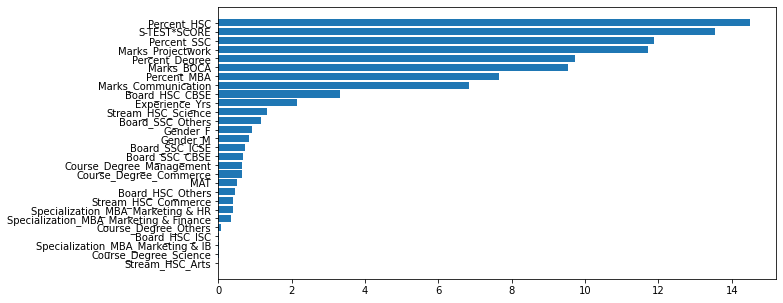

In [72]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(width=catboost_importances, y=catboost_importances_names)

In [73]:
from sklearn.ensemble import VotingClassifier

In [224]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

In [227]:
ridge_clf = Pipeline([
    ('ss', StandardScaler()),
    ('ridge', RidgeClassifier())
])

In [238]:
params_ridge = {
    "ridge__alpha": np.arange(0.1, 10, 0.1)
}

In [239]:
ridge = GridSearchCV(ridge_clf, param_grid=params_ridge, scoring="f1", cv=5, n_jobs=-1, error_score="raise", verbose=1)
ridge.fit(X_rd, y)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('ridge', RidgeClassifier())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='f1', verbose=1)

In [242]:
scaled = StandardScaler().fit_transform(X_rd)
scaled

array([[-0.75888927, -0.48939629,  0.41187325, ...,  0.82788481,
        -0.77735325, -0.17586311],
       [-2.10238374, -1.09770184, -0.24335566, ...,  0.82788481,
        -0.77735325, -0.17586311],
       [-1.02758816, -2.05361055, -1.00778939, ..., -1.20789751,
         1.28641644, -0.17586311],
       ...,
       [ 1.96392618, -0.25824019,  0.43917446, ..., -1.20789751,
         1.28641644, -0.17586311],
       [-1.83368485,  0.7272148 , -0.46176529, ..., -1.20789751,
        -0.77735325,  5.6862407 ],
       [ 1.41936309,  1.14694562,  1.42747806, ...,  0.82788481,
        -0.77735325, -0.17586311]])

In [241]:
ridge.best_score_

0.0841025641025641

In [173]:
def voting_clf(estimators=(decision_tree, random_forest, catboost), weights=None, observations=X_rd)->list:
    prediction = []
    if weights == None:
        weights = [1] * len(estimators)
    for observation in observations.values:
        first_class, second_class = 0, 0
        for i, estimator in enumerate(estimators):
            predict = estimator.predict([observation])
            if predict == 1:
                first_class += weights[i]
            else:
                second_class += weights[i]
        if first_class > second_class:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction

In [43]:
test = pd.read_csv("Test_Features.csv")
test = wrangle(test)
test

,Gender,Percent_SSC,Board_SSC,Percent_HSC,Board_HSC,Stream_HSC,Percent_Degree,Course_Degree,Experience_Yrs,S-TEST*SCORE,Percent_MBA,Specialization_MBA,Marks_Communication,Marks_Projectwork,Marks_BOCA,MAT
0,M,77.12,Others,85.0,Others,Commerce,56.77,Management,0,35.0,56.34,Marketing & IB,56,66,58,0
1,M,83.00,Others,51.0,Others,Science,51.00,Science,0,33.0,58.21,Marketing & HR,50,68,63,0
2,M,48.00,CBSE,63.0,CBSE,Commerce,59.70,Commerce,0,44.2,62.00,Marketing & Finance,52,69,75,1
3,M,52.00,CBSE,55.0,CBSE,Science,68.00,Others,1,0.0,59.99,Marketing & HR,50,64,64,1
4,M,58.00,Others,62.0,Others,Science,58.00,Science,0,75.0,66.46,Marketing & Finance,63,61,65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,M,48.00,Others,54.0,Others,Science,58.00,Management,0,39.0,52.42,Marketing & HR,50,70,53,1
87,M,59.00,ICSE,60.0,ISC,Commerce,62.00,Management,1,0.0,53.37,Marketing & HR,52,50,50,1
88,F,74.00,ICSE,83.0,ISC,Arts,50.00,Others,0,57.0,64.08,Marketing & Finance,66,63,81,1
89,F,79.68,Others,63.5,Others,Science,60.00,Science,0,0.0,67.96,Marketing & HR,64,64,79,1


In [44]:
result = pd.DataFrame(enumerate(voting_clf(estimators=(decision_tree, catboost), weights=[observations=test)), columns=["ID", "Placement"])
result["ID"] += 1
result

SyntaxError: invalid syntax (2310893181.py, line 1)

In [45]:
result_cat = pd.DataFrame(enumerate(catboost.predict(test)), columns=["ID", "Placement"])
result_cat["ID"] += 1
result_cat["Placement"].iloc[50:60]

50    0
51    0
52    0
53    1
54    0
55    0
56    0
57    0
58    0
59    0
Name: Placement, dtype: int64

In [215]:
result_decision_tree = pd.DataFrame(
    {
        "ID": range(1, test.shape[0] + 1),
        "Placement": decision_tree.predict(test)
    }
)
result_decision_tree

,ID,Placement
0,1,0
1,2,0
2,3,0
3,4,1
4,5,0
...,...,...
86,87,0
87,88,1
88,89,1
89,90,0


In [218]:
result_random_forest = pd.DataFrame(
    {
        "ID": range(1, test.shape[0] + 1),
        "Placement": random_forest.predict(test)
    }
)
result_random_forest

,ID,Placement
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
86,87,1
87,88,0
88,89,1
89,90,0


In [204]:
result.to_csv("submission.csv", index=False)

In [46]:
result_cat.to_csv("submission_cat.csv", index=False)

In [220]:
result_decision_tree.to_csv("submission_decision.csv", index=False)

In [221]:
result_random_forest.to_csv("submission_random_forest.csv", index=False)